In [1]:
#Import the libraries
import h5py
import os
import pandas as pd
import numpy as np
import keras 
from keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import seaborn as sns
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Input, Dense, Dropout,Flatten, Reshape,BatchNormalization

In [2]:
# Loads baseline at f=40kHz in given temperature range and sensor path
def load_baseline_data(temp_range,ipath):
    #save working directory
    main_dir = 'E:\Shruti\PythonCodes'
    
    # create an Empty DataFrame object
    dataset1 = pd.DataFrame()

    #Number of frequencies of actuation frequencies
    n_freq = 1

    #Label for frequency in dataset
    filenames = ["pc_f40kHz.h5"]

    #Path for baseline folder
    path = 'E:\Shruti\OGW\OGW_CFRP_Temperature_udam'

    #Get names of different temperature folders 
    folderNames = []
    for i in os.scandir(path):
        folderNames.append(i.path)

    #Temperature indices from input
    ind_temp = (np.array(np.arange(temp_range[0],temp_range[1])))

    #Sensor path index from input
    transch = np.arange(ipath,ipath+1)

    #Read OGW dataset for specified frequency, temperatures and sensor path
    for i in ind_temp:
        os.chdir(folderNames[i])
        for j in np.arange(0,n_freq):
            file_name = filenames[j]
            f = h5py.File(file_name, "r")
            data = f['pitchcatch']
            catchdata = data['catch']
            cdata= pd.DataFrame(np.array(catchdata))
            cdata=cdata.iloc[transch,:]
            dataset1 = pd.concat([dataset1, cdata])
            dataset1 = dataset1.drop(labels=np.arange(6000,13108), axis=1)
            dataset1 = dataset1.drop(labels=np.arange(0,1000), axis=1)
    #Change back to working directory  
    os.chdir(main_dir)
    return dataset1

# Loads D12 data at f=40kHz in given temperature range and sensor path
def load_D12_data(temp_range,ipath):
    #save working directory
    main_dir = 'E:\Shruti\PythonCodes'
    # create an Empty DataFrame object
    dataset1 = pd.DataFrame()

    #Number of frequencies of actuation 40,60,80KHz
    n_freq = 1
    
    #Labels for all frequencies
    filenames = ["pc_f40kHz.h5"]

    #Path for D12 folder
    path = 'E:\Shruti\OGW\OGW_CFRP_Temperature_dam_D12'

    #Get names of different temperature folders 
    folderNames = []
    for i in os.scandir(path):
      folderNames.append(i.path)

    #Specidy temperature indices
    ind_temp = (np.array(np.arange(temp_range[0],temp_range[1])))

    # Using only one senosr path
    transch = np.arange(ipath,ipath+1)

    #Read OGW dataset for specified frequencies and temperatures
    for i in ind_temp:
        os.chdir(folderNames[i])
        for j in np.arange(0,n_freq):
            file_name = filenames[j]
            f = h5py.File(file_name, "r")
            data = f['pitchcatch']
            catchdata = data['catch']
            cdata= pd.DataFrame(np.array(catchdata))
            cdata=cdata.iloc[transch,:]
            dataset1 = pd.concat([dataset1, cdata])
            dataset1 = dataset1.drop(labels=np.arange(6000,13108), axis=1)
            dataset1 = dataset1.drop(labels=np.arange(0,1000), axis=1)
    #Change back to working directory  
    os.chdir(main_dir)
    return dataset1

def load_D16_data(temp_range,ipath):
   
    #save working directory
    main_dir = 'E:\Shruti\PythonCodes'
    # create an Empty DataFrame object
    dataset1 = pd.DataFrame()

    #Number of frequencies of actuation 40,60,80KHz
    n_freq = 1

    #Labels for all frequencies
    filenames = ["pc_f40kHz.h5"]

    #Path for baseline folder
    path = 'E:\Shruti\OGW\OGW_CFRP_Temperature_dam_D16'

    #Get names of different temperature folders 
    folderNames = []
    for i in os.scandir(path):
      folderNames.append(i.path)

    #Specidy temperature indices
    ind_temp = (np.array(np.arange(temp_range[0],temp_range[1])))
    
    # Using only one senosr path
    transch = np.arange(ipath,ipath+1)

    #Read OGW dataset for specified frequencies and temperatures
    for i in ind_temp:
        os.chdir(folderNames[i])
        for j in np.arange(0,n_freq):
            file_name = filenames[j]
            f = h5py.File(file_name, "r")
            data = f['pitchcatch']
            catchdata = data['catch']
            cdata= pd.DataFrame(np.array(catchdata))
            cdata=cdata.iloc[transch,:]
            dataset1 = pd.concat([dataset1, cdata])
            dataset1 = dataset1.drop(labels=np.arange(6000,13108), axis=1)
            dataset1 = dataset1.drop(labels=np.arange(0,1000), axis=1)
    #Change back to working directory  
    os.chdir(main_dir)
    return dataset1

#Noise augmentation 
def add_noise(X,n_copies,beta):
    dataset_n = pd.DataFrame()

    for i in np.arange(0,n_copies):
        mu = 0
        sigma = 1

        #random parameter with standard normal distribution
        r = sigma*np.random.randn(X.shape[1],1) + mu   
        r = np.transpose(r)

        maxX = np.max(X)
        maxX = np.array(maxX)

        noise = beta*r*maxX
        Noisy = X + noise
        dataset_n = pd.concat([dataset_n, pd.DataFrame(Noisy)])
        
    return dataset_n

#MSE between reconstructed signal and original signal
MSE = keras.losses.MeanSquaredError()

def predict(model,test):
    temp = model.predict(test)
    pred = temp.reshape(test.shape[0],test.shape[1])
    return pred 

def compute_mse(test,pred):
    mse = []
    for i in range(test.shape[0]):
        mse.append(MSE(test[i,:],pred[i,:]))
    return mse

#save train history as csv
def save_file(data,filename):
    df = pd.DataFrame (data)
    df.to_csv(filename, index=False)

In [3]:
model = []
paths = []
for i in np.arange(1,7):
    for j in np.arange(7,13):
        paths.append('P'+str(i)+'-'+str(j))

In [4]:
def case_analysis(mse_bl,mse_d12,mse_d16,n_factor,k,c):
    #
    
    sdc = []
    mse = []
    

    path = 'E:\Shruti\PythonCodes\GIT_ultrasonics'
    
    for i in np.arange(1,7):
        for j in np.arange(7,13):
            sdc.append(path + '\P'+str(i)+'-'+str(j)+'_SDC_temp_case'+str(c)+'.csv')
            mse.append(path + '\P'+str(i)+'-'+str(j)+'_MSE_temp_case'+str(c)+'.csv')
      
    #Normalize MSE 
    mse_bl_n = mse_bl/n_factor
    mse_d12_n = mse_d12/n_factor
    mse_d16_n = mse_d16/n_factor

    n = mse_bl.shape[0]
    mse_write = (np.concatenate([mse_bl_n.reshape(n,1),mse_d12_n.reshape(n,1),mse_d16_n.reshape(n,1)], axis=1))
    mse_write = pd.DataFrame(mse_write, columns=["MSE_BL","MSE_D12","MSE_D16"])

    med_bl = []
    med_D12 = []
    med_D16 = []
    sdc_D12 = []
    sdc_D16 = []
    
    for i in range(20):
        #Compute median of 10 test samples
        med_bl.append(np.median(mse_write.iloc[i*10:10*i+10,0]))
        med_D12.append(np.median(mse_write.iloc[i*10:10*i+10,1]))
        med_D16.append(np.median(mse_write.iloc[i*10:10*i+10,2]))
        
        #Compute SDC as difference in median
        sdc_D12.append(np.abs(med_D12[i] - med_bl[i]))
        sdc_D16.append(np.abs(med_D16[i] - med_bl[i]))

    med_bl = np.array(med_bl)
    med_D12 = np.array(med_D12)
    med_D16 = np.array(med_D16)
    sdc_D12 = np.array(sdc_D12)
    sdc_D16 = np.array(sdc_D16)
    m = med_bl.shape[0]

    #Store the output files
    #MSE
    mse_med = (np.concatenate([med_bl.reshape(m,1),med_D12.reshape(m,1),med_D16.reshape(m,1)], axis=1))
    mse_med = pd.DataFrame(mse_med, columns=["MSE_BL","MSE_D12","MSE_D16"])
    save_file(mse_med,mse[k])
    
    #SDC
    sdc_write = (np.concatenate([sdc_D12.reshape(m,1),sdc_D16.reshape(m,1)], axis=1))
    sdc_med = pd.DataFrame(sdc_write, columns=["SDC_D12","SDC_D16"])
    save_file(sdc_med,sdc[k])


For sensor path : P1-7
Train dataset loading completed
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5000, 1)]         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5000, 16)          144       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2500, 16)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2500, 16)          4112      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1250, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dens

88/88 [==============================] - 10s 111ms/step - loss: 2.2180e-06 - val_loss: 2.3146e-06
Epoch 55/200
88/88 [==============================] - 10s 111ms/step - loss: 2.1871e-06 - val_loss: 2.2897e-06
Epoch 56/200
88/88 [==============================] - 10s 112ms/step - loss: 2.1585e-06 - val_loss: 2.2687e-06
Epoch 57/200
88/88 [==============================] - 10s 113ms/step - loss: 2.1323e-06 - val_loss: 2.2373e-06
Epoch 58/200
88/88 [==============================] - 10s 116ms/step - loss: 2.1079e-06 - val_loss: 2.2264e-06
Epoch 59/200
88/88 [==============================] - 10s 117ms/step - loss: 2.0853e-06 - val_loss: 2.2153e-06
Epoch 60/200
88/88 [==============================] - 10s 117ms/step - loss: 2.0644e-06 - val_loss: 2.1832e-06
Epoch 61/200
88/88 [==============================] - 10s 116ms/step - loss: 2.0428e-06 - val_loss: 2.1634e-06
Epoch 62/200
88/88 [==============================] - 10s 112ms/step - loss: 2.0240e-06 - val_loss: 2.1399e-06
Epoch 63/200
8

88/88 [==============================] - 10s 109ms/step - loss: 1.6037e-06 - val_loss: 1.7721e-06
Epoch 128/200
88/88 [==============================] - 10s 110ms/step - loss: 1.6009e-06 - val_loss: 1.7787e-06
Epoch 129/200
88/88 [==============================] - 10s 113ms/step - loss: 1.5981e-06 - val_loss: 1.7752e-06
Epoch 130/200
88/88 [==============================] - 10s 111ms/step - loss: 1.5956e-06 - val_loss: 1.7690e-06
Epoch 131/200
88/88 [==============================] - 10s 110ms/step - loss: 1.5961e-06 - val_loss: 1.7692e-06
Epoch 132/200
88/88 [==============================] - 10s 112ms/step - loss: 1.5920e-06 - val_loss: 1.7734e-06
Epoch 133/200
88/88 [==============================] - 10s 113ms/step - loss: 1.5899e-06 - val_loss: 1.7674e-06
Epoch 134/200
88/88 [==============================] - 10s 114ms/step - loss: 1.5889e-06 - val_loss: 1.7552e-06
Epoch 135/200
88/88 [==============================] - 10s 114ms/step - loss: 1.5886e-06 - val_loss: 1.7680e-06
Epoch 

88/88 [==============================] - 10s 114ms/step - loss: 1.5076e-06 - val_loss: 1.7006e-06
Training completed
Test dataset loading completed


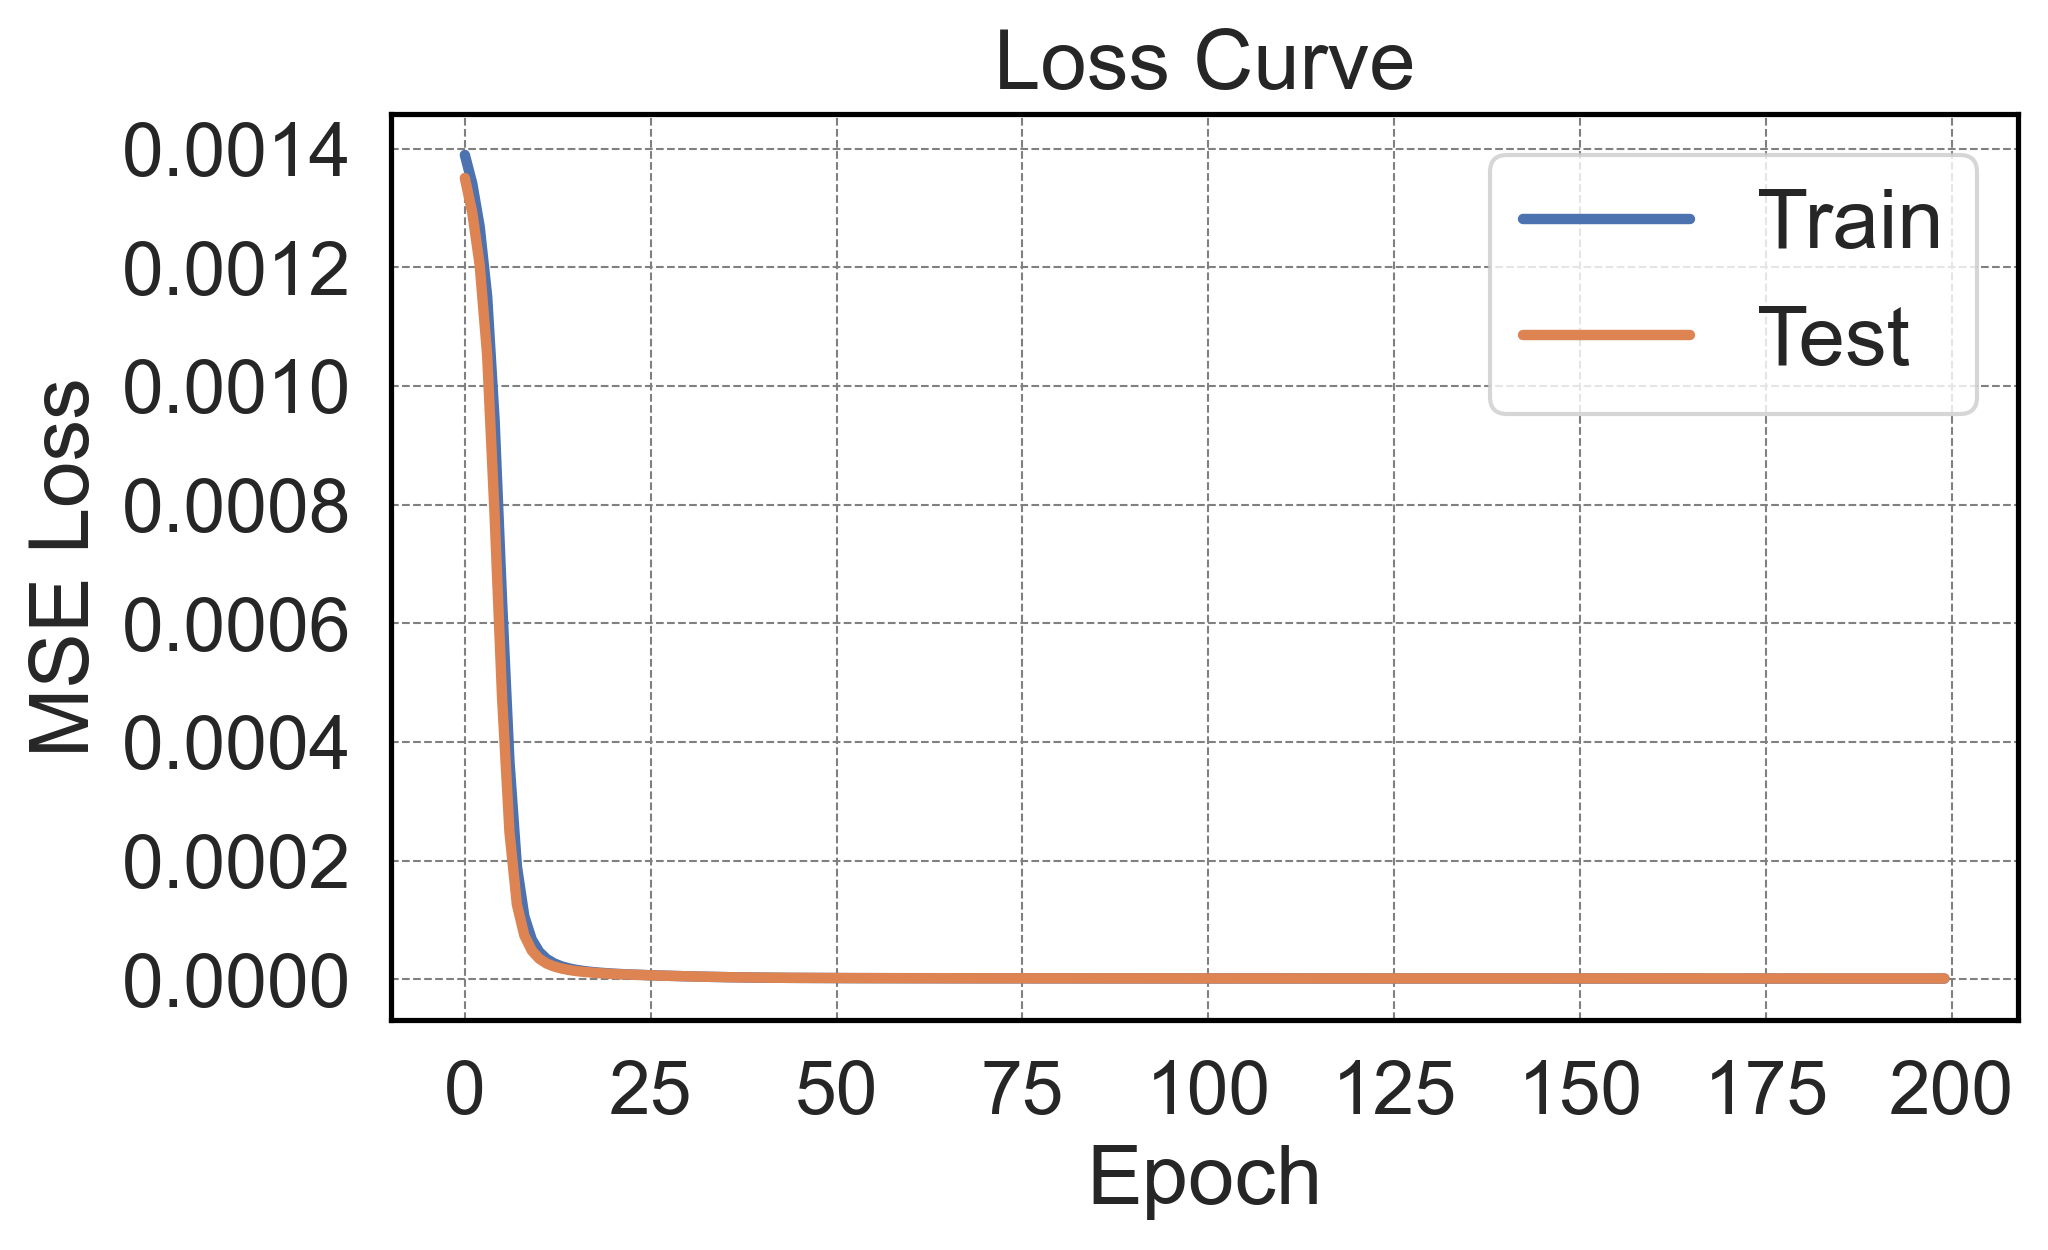

In [6]:
#pind is path index for 36 transmission paths
pind = np.concatenate((np.arange(5,11),np.arange(15,21),np.arange(24,30),np.arange(32,38),np.arange(39,51)),axis=0)

for k in np.arange(0,36):
    
    print('For sensor path :',paths[k])
    
    #panth index
    ipath = pind[k]
    
    #Train data : temperature range 20-60
    temp_train = load_baseline_data([1,321],ipath)
    print("Train dataset loading completed")
    
    #Spliting data and labels into train, test and validation
    x_train, x_test1, y_train, y_test1 = train_test_split(temp_train , temp_train , test_size=0.3)
    x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.2)
    
    #Noise augmentation with SNR of 50 dB
    beta=0.001
    x_train_noisy = add_noise(x_train,50,beta)
    x_train_noisy = np.asarray(x_train_noisy).reshape(x_train_noisy.shape[0],x_train_noisy.shape[1],1) 
    x_val_noisy = add_noise(x_val,50,beta)
    x_val_noisy = np.asarray(x_val_noisy).reshape(x_val_noisy.shape[0],x_val_noisy.shape[1],1)
    test_bl = add_noise(x_test,10,beta)
    test_bl = np.asarray(test_bl).reshape(test_bl.shape[0],test_bl.shape[1])
    
    #Autoencoder architecture
    input_img = keras.Input(shape=(5000, 1))
    x = layers.Conv1D(16, 8, activation='relu', padding='same')(input_img)
    x = layers.MaxPooling1D((2), padding='same')(x)
    x = layers.Conv1D(16, 16, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling1D(2, padding='same')(x)
    flatten_1 = Flatten()(encoded)
    code = Dense(16, activation='relu')(flatten_1)
    flatten_2 = Dense(flatten_1.shape[1], activation='relu')(code)
    flatten_2 = Reshape(encoded.shape[1:3])(flatten_2)
    x = layers.Conv1D(16, 32, activation='relu', padding='same')(flatten_2)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(16, 16, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    decoded = layers.Conv1D(1, 1, activation='linear', padding='same')(x)
    autoencoder = tf.keras.Model(input_img, decoded)    
    autoencoder.compile(optimizer=Adam(learning_rate=5e-6), loss='mse')
    autoencoder.summary()

    history=autoencoder.fit(x_train_noisy, x_train_noisy,
                    epochs=200,
                    batch_size=128,
                    validation_data=(x_val_noisy, x_val_noisy))  
    print("Training completed")
    
    #Path to store output files
    os.chdir('E:\Shruti\PythonCodes\GIT_ultrasonics')
    
    #Plot loss surve on log scale
    sns.set(style="whitegrid", rc={'figure.figsize':(7,4),'figure.dpi':300}) 
    tickfont = {'size'   : 25}
    labelfont = {'size'   : 30}
    fig, ax = plt.subplots()
    for spine in ax.spines.values():
            spine.set_edgecolor('black')
    plt.plot(history.history['loss'], linewidth=2.5)
    plt.plot(history.history['val_loss'], linewidth=2.5)
    plt.title('Loss Curve', fontsize=20)
    plt.ylabel('MSE Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.legend(['Train', 'Test'], loc='upper right', fontsize=20)
    plt.xticks(fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.savefig(paths[k]+'_LossCurve.png')

    # convert the history.history dict to a pandas DataFrame and store    
    hist_df = pd.DataFrame(history.history)
    save_file(hist_df,paths[k]+'_training_history.csv')

    #Save trained model
    autoencoder.save(paths[k]+'.h5')
    
    #Read test data
    test_bl_case1 = load_baseline_data([1,21],ipath)
    test_bl_case2 = load_baseline_data([22,42],ipath)
    test_bl_case3 = load_baseline_data([42,62],ipath)
    test_bl_case4 = load_baseline_data([63,83],ipath)

    test_D12_case1 = load_D12_data([1,21],ipath)
    test_D12_case2 = load_D12_data([22,42],ipath)
    test_D12_case3 = load_D12_data([42,62],ipath)
    test_D12_case4 = load_D12_data([63,83],ipath)

    test_D16_case1 = load_D16_data([1,21],ipath)
    test_D16_case2 = load_D16_data([22,42],ipath)
    test_D16_case3 = load_D16_data([42,62],ipath)
    test_D16_case4 = load_D16_data([63,83],ipath)
    print("Test dataset loading completed")
    
    #Noise augmentation of test data
    beta=0.001
    noisy_test_bl_case1 = add_noise(test_bl_case1 ,10,beta)
    noisy_test_bl_case2 = add_noise(test_bl_case2 ,10,beta)
    noisy_test_bl_case3 = add_noise(test_bl_case3 ,10,beta)
    noisy_test_bl_case4 = add_noise(test_bl_case4 ,10,beta)

    noisy_test_D12_case1 = add_noise(test_D12_case1 ,10,beta)
    noisy_test_D12_case2 = add_noise(test_D12_case2 ,10,beta)
    noisy_test_D12_case3 = add_noise(test_D12_case3 ,10,beta)
    noisy_test_D12_case4 = add_noise(test_D12_case4 ,10,beta)

    noisy_test_D16_case1 = add_noise(test_D16_case1 ,10,beta)
    noisy_test_D16_case2 = add_noise(test_D16_case2 ,10,beta)
    noisy_test_D16_case3 = add_noise(test_D16_case3 ,10,beta)
    noisy_test_D16_case4 = add_noise(test_D16_case4 ,10,beta)
    
    #Compute MSE
    #damaged
    mse_d12_case1 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D12_case1)),np.array(noisy_test_D12_case1)))
    mse_d12_case2 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D12_case2)),np.array(noisy_test_D12_case2)))
    mse_d12_case3 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D12_case3)),np.array(noisy_test_D12_case3)))
    mse_d12_case4 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D12_case4)),np.array(noisy_test_D12_case4)))
    
    mse_d16_case1 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D16_case1)),np.array(noisy_test_D16_case1)))
    mse_d16_case2 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D16_case2)),np.array(noisy_test_D16_case2)))
    mse_d16_case3 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D16_case3)),np.array(noisy_test_D16_case3)))
    mse_d16_case4 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_D16_case4)),np.array(noisy_test_D16_case4)))
    
    #undamaged
    mse_bl_case1 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_bl_case1)),np.array(noisy_test_bl_case1)))
    mse_bl_case2 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_bl_case2)),np.array(noisy_test_bl_case2)))
    mse_bl_case3 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_bl_case3)),np.array(noisy_test_bl_case3)))
    mse_bl_case4 = np.array(compute_mse(np.array(predict(autoencoder,noisy_test_bl_case4)),np.array(noisy_test_bl_case4)))
    
    #Normalization factor computed for each path for all four cases
    n_fact = np.mean(np.mean(np.concatenate([mse_bl_case1.reshape(200,1),mse_bl_case2.reshape(200,1),mse_bl_case3.reshape(200,1),mse_bl_case4.reshape(200,1)],axis=1)))
    
    #Casewise analysis for 4 temperature cases
    case_analysis(mse_bl_case1,mse_d12_case1,mse_d16_case1,n_fact,k,1)
    case_analysis(mse_bl_case2,mse_d12_case2,mse_d16_case2,n_fact,k,2)
    case_analysis(mse_bl_case3,mse_d12_case3,mse_d16_case3,n_fact,k,3)
    case_analysis(mse_bl_case4,mse_d12_case4,mse_d16_case4,n_fact,k,4)